# Network Analysis Lab

Complete the following exercises to help solidify your understanding of network analysis.

In [1]:
import networkx as nx
import nxviz
import community
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

## U.S. Mens Basketball Data Set

In the `us_mens_basketball.csv` data set, each row represents an single basketball player's participation in a single event at a single Olympics. 

In [2]:
basketball = pd.read_csv('../data/us_mens_basketball.csv')

In [3]:
basketball.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,351,Julius Shareef Abdur-Rahim,M,23.0,202.0,104.0,United States,USA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,Gold
1,2636,"Stephen Todd ""Steve"" Alford",M,19.0,185.0,74.0,United States,USA,1984 Summer,1984,Summer,Los Angeles,Basketball,Basketball Men's Basketball,Gold
2,2863,Walter Ray Allen,M,25.0,192.0,93.0,United States,USA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,Gold
3,3874,"William Lloyd ""Willie"" Anderson, Jr.",M,21.0,200.0,86.0,United States,USA,1988 Summer,1988,Summer,Seoul,Basketball,Basketball Men's Basketball,Bronze
4,4505,Carmelo Kyan Anthony,M,20.0,203.0,109.0,United States,USA,2004 Summer,2004,Summer,Athina,Basketball,Basketball Men's Basketball,Bronze


## 1. Transform this data set into one that can be turned into a graph where the entities are represented by the Name field and the relationships are represented by whether the players played in the same Olympics together (Games field).

Sort descending by the number of pairwise interactions. Which pair of players have competed in the most Olympics together?

In [4]:
#Connect individuals (represented by their Name) that have the same Games. 

column_edge = 'Games'
column_ID = 'Name'

data_to_merge = basketball[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN

#To create connections between names who have the same game,
#join data with itself on the 'Games' column.

data_to_merge = data_to_merge.merge(data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge)

#By joining the data with itself, names will have a connection with themselves.
#Remove self connections, to keep only connected names who are different.

d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]
    
#To avoid counting twice the connections (name 1 connected to name 2 and name 2 connected to name 1)
#we force the first Name to be "lower" then Name_2
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)
d
dsmall = d.head(2)

## 2. Use the `from_pandas_edgelist` method to turn the data frame into a graph.

C:\Users\krist\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


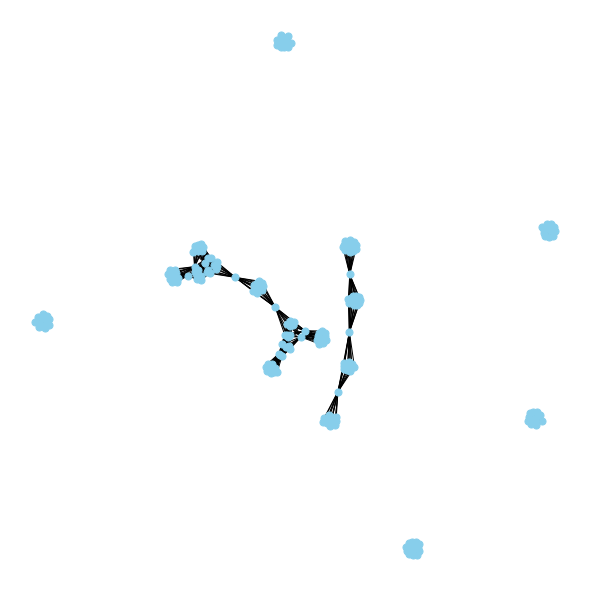

In [5]:
G = nx.from_pandas_edgelist(d, 'Name', 'Name_2')
plt.figure(figsize=(8,8)) 
pos = nx.fruchterman_reingold_layout(G)

nx.draw(G, pos, with_labels=False, node_color="skyblue", node_size = 50) #colour indicated here
plt.show()

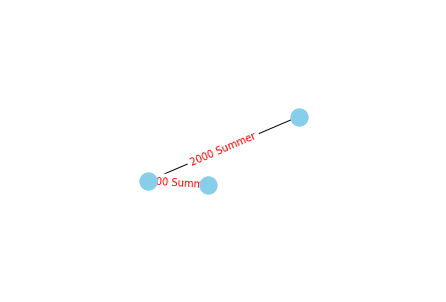

In [6]:
# example of adding edge lables manually (for only a few values)

Gs = nx.from_pandas_edgelist(dsmall, 'Name', 'Name_2')

dic = {('Julius Shareef Abdur-Rahim','Walter Ray Allen'):'2000 Summer', 
                                                ('Julius Shareef Abdur-Rahim','Vincent Lamont "Vin" Baker'):'2000 Summer'}

nx.draw(Gs, pos, with_labels=False, node_color="skyblue")
nx.draw_networkx_edge_labels(Gs,pos,edge_labels=dic, font_color='red')
plt.show()

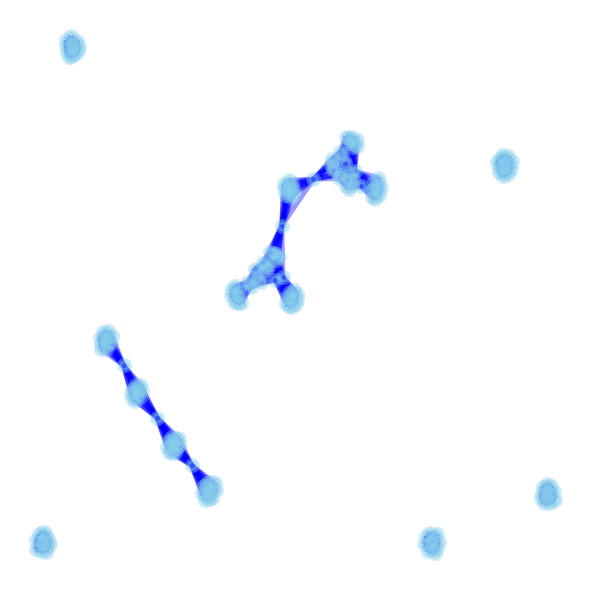

In [7]:
#Graph with custom design nodes:

plt.figure(figsize=(8,8)) 
nx.draw(G,
        with_labels=False,
        
        #node customizations
        node_size=100,
        node_color="skyblue",
        node_shape="o",
        alpha=0.4,
        linewidths=5,
        
        #label customization
        font_size=18,
        font_color="#333333",
        font_weight="bold",
        
        #edge customization
        width=5,
        edge_color="blue",
        style="solid"
       )
plt.show()


## 3. Compute and print the following graph statistics for the graph:

- Number of nodes
- Number of edges
- Average degree
- Density

In [8]:
print(f'The number of nodes is {len(G.nodes())}')
print(f'The number of edges is {len(G.edges())}')
print(f'Average degree is {round(sum(dict(nx.degree(G)).values()) / len(G.nodes()), 3)}')
print(f'Density is {round(nx.density(G), 3)}')

The number of nodes is 196
The number of edges is 1232
Average degree is 12.571
Density is 0.064


## 4. Compute betweenness centrality for the graph and print the top 5 nodes with the highest centrality.

In [9]:
def draw(G, pos, measures, measure_name, logscale=False, labels=False):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.Blues, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_edgecolor('k')
    
    if logscale:
        nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    
    if labels:
        labels = nx.draw_networkx_labels(G, pos)
        
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

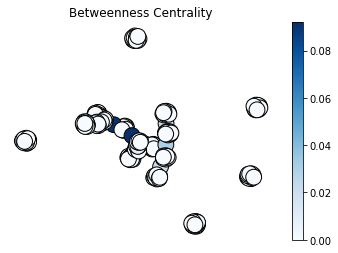

In [10]:
draw(G, pos, nx.betweenness_centrality(G), 'Betweenness Centrality')

In [11]:
between = nx.betweenness_centrality(G)
between_sorted = {key: value for key, value in sorted(between.items(), reverse = True, key=lambda item: item[1])}

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

top5 = take(5, between_sorted.items())
pd.DataFrame(top5).rename(columns = {0: 'Name', 1: 'betweenness_centrality'})

,Name,betweenness_centrality
0,Gary Dwayne Payton,0.091938
1,Jason Frederick Kidd,0.091356
2,Carmelo Kyan Anthony,0.047423
3,David Maurice Robinson,0.032662
4,"William Marion ""Bill"" Hougland",0.030241


## 5. Compute Eigenvector centrality for the graph and print the top 5 nodes with the highest centrality.

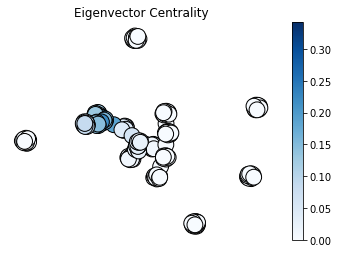

In [12]:
draw(G, pos, nx.eigenvector_centrality(G, max_iter=1000), 'Eigenvector Centrality')


In [13]:
eigen = nx.eigenvector_centrality(G, max_iter=1000)
eigen_sorted = {key: value for key, value in sorted(eigen.items(), reverse = True, key=lambda item: item[1])}

top5 = take(5, eigen_sorted.items())
pd.DataFrame(top5).rename(columns = {0: 'Name', 1: 'eigenvector_centrality'})

,Name,eigenvector_centrality
0,Carmelo Kyan Anthony,0.341810
1,LeBron Raymone James,0.288421
2,Kobe Bean Bryant,0.224292
3,"Christopher Emmanuel ""Chris"" Paul",0.224292
4,Deron Michael Williams,0.224292


## 6. Compute degree centrality for the graph and print the top 5 nodes with the highest centrality.

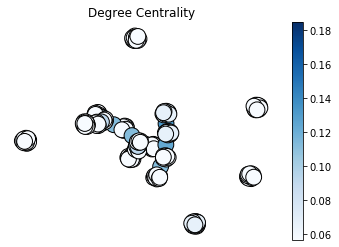

In [14]:
draw(G, pos, nx.degree_centrality(G), 'Degree Centrality')

In [15]:
degr = nx.degree_centrality(G)
degr_sorted = {key: value for key, value in sorted(degr.items(), reverse = True, key=lambda item: item[1])}

top5 = take(5, degr_sorted.items())
pd.DataFrame(top5).rename(columns = {0: 'Name', 1: 'degree_centrality'})

,Name,degree_centrality
0,Carmelo Kyan Anthony,0.184615
1,David Maurice Robinson,0.143590
2,LeBron Raymone James,0.133333
3,"Robert Albert ""Bob"" Kurland",0.133333
4,"William Marion ""Bill"" Hougland",0.123077


## 7. Generate a network visualization for the entire graph using a Kamada-Kawai force-directed layout.

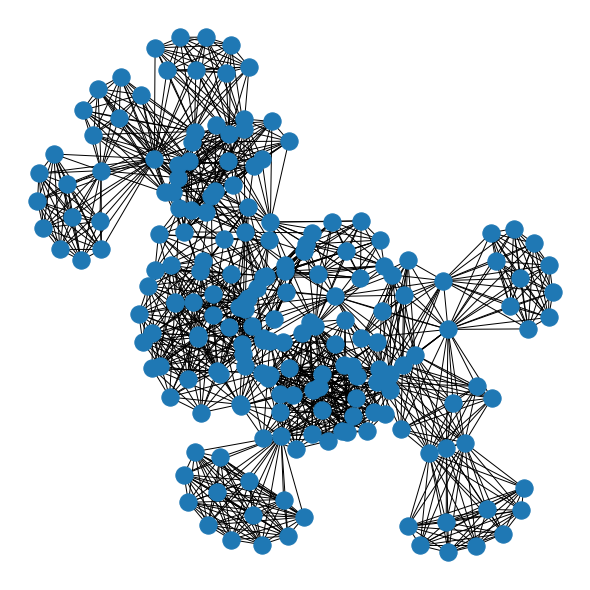

In [16]:
G = nx.from_pandas_edgelist(d, 'Name', 'Name_2')
plt.figure(figsize=(8,8)) 
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos)
plt.show()

## 8. Create and visualize an ego graph for the player with the highest betweenness centrality.

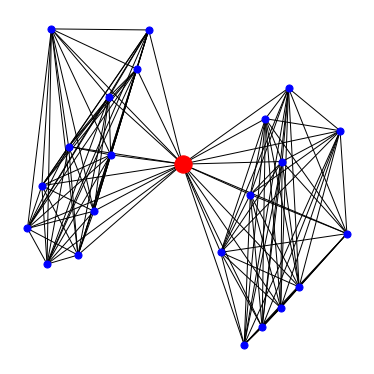

In [17]:
plt.figure(figsize=(5,5)) #size of the graph
largest_hub = take(5, between_sorted.keys())[0]
hub_ego = nx.ego_graph(G, largest_hub)
# Draw graph
nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=False)
# Draw ego as large and red
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], node_size=300, node_color='r')
plt.show()

## 9. Identify the communities within the entire graph and produce another visualization of it with the nodes color-coded by the community they belong to.

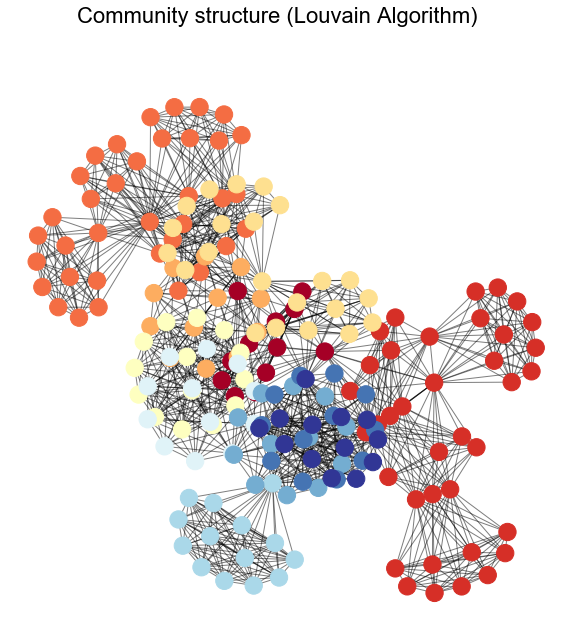

In [18]:
partition = community.best_partition(G)
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx_nodes(G, pos, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
#nx.draw_networkx_labels(G, pos)
plt.suptitle('Community structure (Louvain Algorithm)',fontsize=22,fontname='Arial')
plt.show()

## Bonus: Hierarchical Graphs

Thus far, we have analyzed graphs where the nodes represented individual players and the edges represented Olympic games that they have competed in together. We can analyze the data at a higher level if we wanted to, strippping out the players as entities and analyzing the data at the Games level. To do this, we would need to reconstruct the graph so that the *Games* field represents the entities and then use the player names as the edge criteria so that there would be an edge between two Olympic games if an player played in both of them. You already have the tools in your toolbox to be able to do this, so give it a try. 

### Create a graph with Games as the entities and then print out the graph statistics.

### Generate a network visualization of this graph using the layout of your choice.